In [2]:
from hybridbrep import HPart, HybridPredictor, GeneralConvEncDec
import meshplot as mp
import torch
import numpy as np
import torch_geometric as tg
import pytorch_lightning as pl
from tqdm import tqdm
from matplotlib import pyplot as plt

In [3]:
part_path = '../../datasets/frame_guide/fg1.x_t'
#part_path = '../../caddata/frame_guide/fg1.x_t'

In [13]:
# Training Parameters
num_epochs = 2000

model = GeneralConvEncDec(emb_dim=64, dec_dim=1024, dec_layers=4).to('cuda')
data = HPart(part_path, n_samples=500, normalize=True, sort_frac=0.3).data.to('cuda')

# Train Model
losses=[]
optimizer = model.configure_optimizers()
for epoch in tqdm(range(num_epochs)):
    optimizer.zero_grad()
    loss = model.training_step(data, 0)
    loss.backward()
    losses.append(loss.detach().to('cpu').item())
    optimizer.step()


100%|██████████| 2000/2000 [00:22<00:00, 88.29it/s]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.002912…

Face 11:


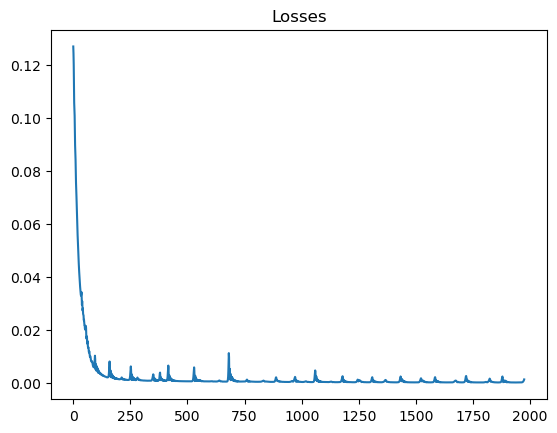

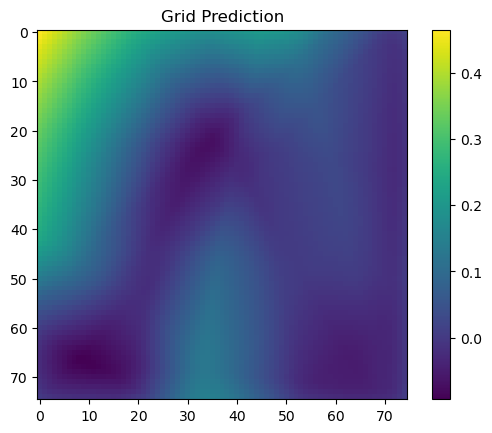

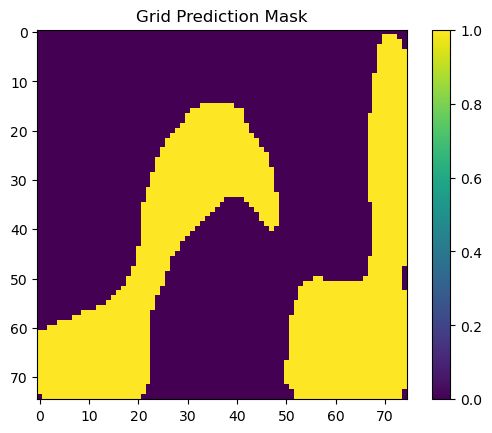

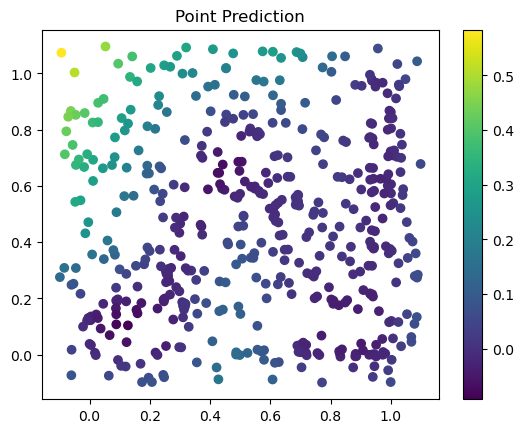

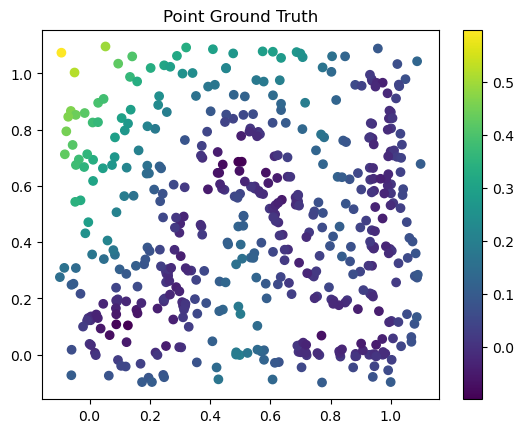

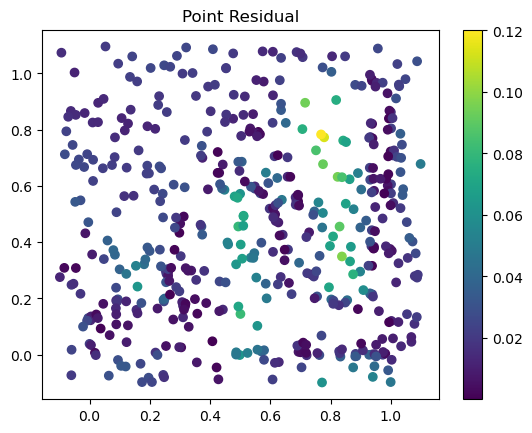

In [14]:
# Visualize Results
with torch.no_grad():

    n_curves, n_c_samples, c_sample_dim = data.curve_samples.shape
    edge_coords = torch.linspace(0.,1.,n_c_samples,device=data.curve_samples.device).repeat(n_curves).reshape((n_curves,-1))

    grid_size = 75
    fp, ep = model.grid_enc_dec(data,grid_size)
    fp = fp.to('cpu')
    ep = ep.to('cpu')

    f_codes,fp_batch,e_codes,ep_batch = model(data, data.surface_coords, edge_coords)
    fp_batch = fp_batch.to('cpu')
    ep_batch = ep_batch.to('cpu')
    del edge_coords
   
    mask = fp[:,3].reshape((-1,grid_size,grid_size)).flip(dims=(2,)).numpy()
    mask_batch = fp_batch[:,-1].numpy().reshape((data.surface_coords.shape[0],-1))
    uv_batch = data.surface_coords.to('cpu').numpy()

    #m_points = points[mask <= 0]
    plt.plot(losses[25:])
    plt.title('Losses')
    
    # Point Cloud Plotting
    n_faces = data.surface_samples.shape[0]

    plot = mp.plot(ep.numpy(),shading={'point_color':'green','point_size':0.1}, return_plot=True)
    fp_rand = fp.numpy()[np.random.choice(fp.shape[0], 30000,replace=False)]
    xyz = fp_rand[:,:3]
    m = fp_rand[:,3]
    fp_color = (m <= 0.015)
    plot.add_points(xyz,c=fp_color,shading={'point_size':0.1})
    #grid_plot = mp.plot(fp_xyz,c=fp_color,shading={'point_size':0.2},return_plot=True)
    #grid_plot.add_points(ep.numpy(), shading={'point_color':'green','point_size':0.3})

    #grid_face_points = fp.reshape((n_faces,-1,4))
    #grid_edge_points = fp.reshape((n_curves,-1))



    # Mask Plotting
    faces_to_plot = [11] # range(mask.shape[0])
    for f_idx in faces_to_plot:
        print(f'Face {f_idx}:')
        plt.figure()
        plt.imshow(mask[f_idx].T)
        plt.title('Grid Prediction')
        plt.colorbar()
        plt.figure()
        plt.imshow(mask[f_idx].T <= 0)
        plt.title('Grid Prediction Mask')
        plt.colorbar()
        plt.figure()
        plt.scatter(uv_batch[f_idx,:,0],uv_batch[f_idx,:,1],c=mask_batch[f_idx])
        plt.title('Point Prediction')
        plt.colorbar()
        plt.figure()
        plt.scatter(uv_batch[f_idx,:,0],uv_batch[f_idx,:,1],c=data.surface_samples[f_idx,:,-1].to('cpu').numpy())
        plt.title('Point Ground Truth')
        plt.colorbar()
        plt.figure()
        plt.scatter(uv_batch[f_idx,:,0],uv_batch[f_idx,:,1],c=np.abs((data.surface_samples[f_idx,:,-1].to('cpu').numpy()-mask_batch[f_idx])))
        plt.title('Point Residual')
        plt.colorbar()

    del data
    del model

    torch.cuda.empty_cache()

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.007541…

Face 11:


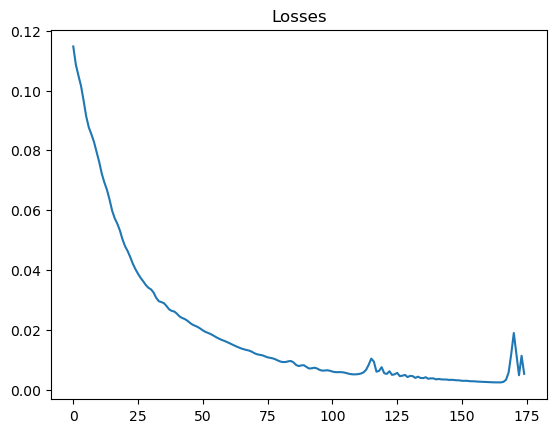

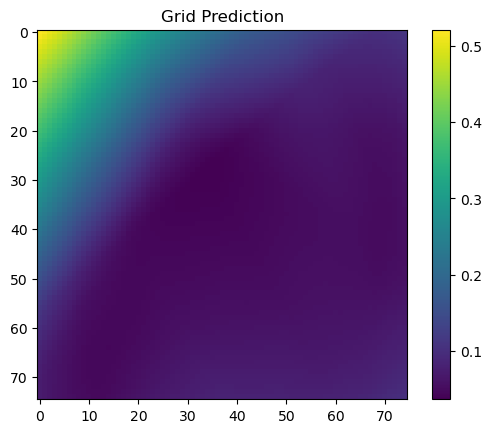

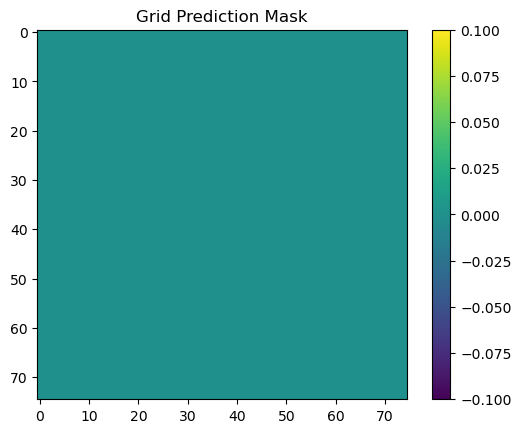

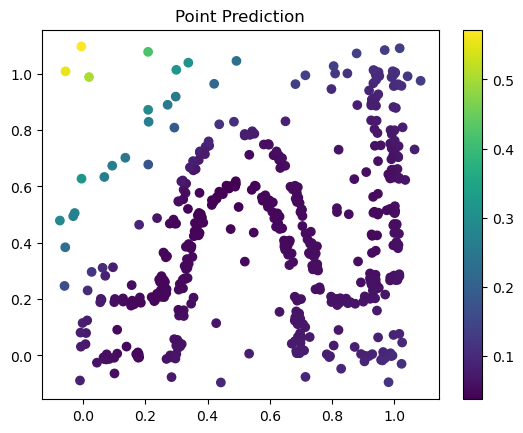

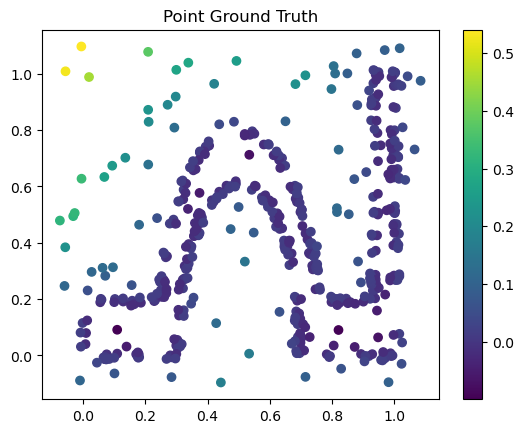

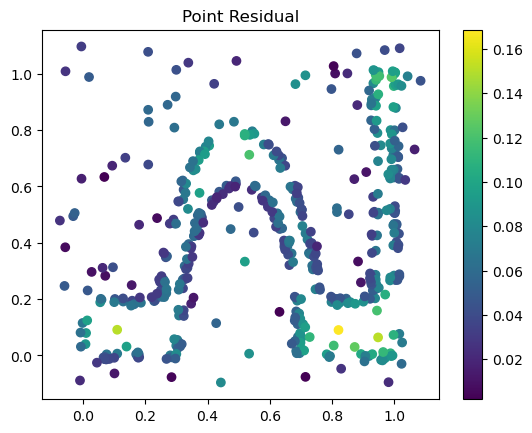

In [8]:
# Visualize Results
with torch.no_grad():

    n_curves, n_c_samples, c_sample_dim = data.curve_samples.shape
    edge_coords = torch.linspace(0.,1.,n_c_samples,device=data.curve_samples.device).repeat(n_curves).reshape((n_curves,-1))

    grid_size = 75
    fp, ep = model.grid_enc_dec(data,grid_size)
    fp = fp.to('cpu')
    ep = ep.to('cpu')

    f_codes,fp_batch,e_codes,ep_batch = model(data, data.surface_coords, edge_coords)
    fp_batch = fp_batch.to('cpu')
    ep_batch = ep_batch.to('cpu')
    del edge_coords
   
    mask = fp[:,3].reshape((-1,grid_size,grid_size)).flip(dims=(2,)).numpy()
    mask_batch = fp_batch[:,-1].numpy().reshape((data.surface_coords.shape[0],-1))
    uv_batch = data.surface_coords.to('cpu').numpy()

    #m_points = points[mask <= 0]
    plt.plot(losses[25:])
    plt.title('Losses')
    
    # Point Cloud Plotting
    n_faces = data.surface_samples.shape[0]

    plot = mp.plot(ep.numpy(),shading={'point_color':'green','point_size':0.1}, return_plot=True)
    fp_rand = fp.numpy()[np.random.choice(fp.shape[0], 30000,replace=False)]
    xyz = fp_rand[:,:3]
    m = fp_rand[:,3]
    fp_color = (m <= 0.015)
    plot.add_points(xyz,c=fp_color,shading={'point_size':0.1})
    #grid_plot = mp.plot(fp_xyz,c=fp_color,shading={'point_size':0.2},return_plot=True)
    #grid_plot.add_points(ep.numpy(), shading={'point_color':'green','point_size':0.3})

    #grid_face_points = fp.reshape((n_faces,-1,4))
    #grid_edge_points = fp.reshape((n_curves,-1))



    # Mask Plotting
    faces_to_plot = [11] # range(mask.shape[0])
    for f_idx in faces_to_plot:
        print(f'Face {f_idx}:')
        plt.figure()
        plt.imshow(mask[f_idx].T)
        plt.title('Grid Prediction')
        plt.colorbar()
        plt.figure()
        plt.imshow(mask[f_idx].T <= 0)
        plt.title('Grid Prediction Mask')
        plt.colorbar()
        plt.figure()
        plt.scatter(uv_batch[f_idx,:,0],uv_batch[f_idx,:,1],c=mask_batch[f_idx])
        plt.title('Point Prediction')
        plt.colorbar()
        plt.figure()
        plt.scatter(uv_batch[f_idx,:,0],uv_batch[f_idx,:,1],c=data.surface_samples[f_idx,:,-1].to('cpu').numpy())
        plt.title('Point Ground Truth')
        plt.colorbar()
        plt.figure()
        plt.scatter(uv_batch[f_idx,:,0],uv_batch[f_idx,:,1],c=np.abs((data.surface_samples[f_idx,:,-1].to('cpu').numpy()-mask_batch[f_idx])))
        plt.title('Point Residual')
        plt.colorbar()

    del data
    del model

    torch.cuda.empty_cache()